In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
# There are 4 Taxi NYC Trips datasets in my local directory, we are going to iterate through that directory and join it all into a big df
path = r'C://Users//awais//OneDrive//Desktop//Data Science//Maven Analytics//taxi_trips'
filenames = glob.glob(path + "//*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)

C:\Users\awais\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
big_frame.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,1.0,2017-01-01 09:00:01.000,2017-01-01 09:03:56.000,N,1.0,74,41,1.0,0.7,5.0,0.0,0.5,0.0,0.0,0.3,5.8,2.0,1.0,NaN
1,1.0,2017-01-01 18:57:55.000,2017-01-01 19:01:16.000,N,1.0,42,41,1.0,0.7,5.0,0.0,0.5,0.0,0.0,0.3,5.8,2.0,1.0,NaN
2,2.0,2017-01-02 06:55:47.000,2017-01-02 06:58:54.000,N,1.0,42,41,1.0,0.7,5.0,0.0,0.5,0.0,0.0,0.3,5.8,2.0,1.0,NaN
3,2.0,2017-01-02 14:34:17.000,2017-01-02 14:39:29.000,N,1.0,74,41,1.0,0.7,5.0,0.0,0.5,0.0,0.0,0.3,5.8,2.0,1.0,NaN
4,1.0,2017-01-03 06:12:30.000,2017-01-03 06:15:56.000,N,1.0,42,41,1.0,0.7,5.0,0.0,0.5,0.0,0.0,0.3,5.8,2.0,1.0,NaN


In [4]:
#Lets have a look at data types
big_frame.dtypes

VendorID                 float64
lpep_pickup_datetime      object
lpep_dropoff_datetime     object
store_and_fwd_flag        object
RatecodeID               float64
PULocationID               int64
DOLocationID               int64
passenger_count          float64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
payment_type             float64
trip_type                float64
congestion_surcharge     float64
dtype: object

In [5]:
#Looking at the unique values for each feature
big_frame.nunique()

VendorID                        2
lpep_pickup_datetime     23288282
lpep_dropoff_datetime    23257942
store_and_fwd_flag              2
RatecodeID                      7
PULocationID                  262
DOLocationID                  263
passenger_count                10
trip_distance                8314
fare_amount                 10758
extra                         110
mta_tax                        29
tip_amount                   4165
tolls_amount                 1346
improvement_surcharge          12
total_amount                16257
payment_type                    5
trip_type                       2
congestion_surcharge            9
dtype: int64

In [6]:
#As you can see, there are some missing values
big_frame.isnull().sum()

VendorID                   942199
lpep_pickup_datetime            0
lpep_dropoff_datetime           0
store_and_fwd_flag         942199
RatecodeID                 942199
PULocationID                    0
DOLocationID                    0
passenger_count            942199
trip_distance                   0
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           2
total_amount                    0
payment_type               942199
trip_type                  942653
congestion_surcharge     22036551
dtype: int64

In [7]:
pd.options.display.float_format = "{:,.2f}".format
big_frame.describe()
#Weirdly enough the trip_distance and fare_amount shows negative values, which is most likely the wrong data entry so lets explore that further

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,"27,383,872.00","27,383,872.00","28,326,071.00","28,326,071.00","27,383,872.00","28,326,071.00","28,326,071.00","28,326,071.00","28,326,071.00","28,326,071.00","28,326,071.00","28,326,069.00","28,326,071.00","27,383,872.00","27,383,418.00","6,289,520.00"
mean,1.82,1.11,110.59,129.01,1.35,3.87,13.18,0.40,0.48,1.08,0.18,0.29,15.72,1.47,1.03,0.42
std,0.38,0.70,74.16,76.88,1.02,296.91,11.87,0.57,0.11,2.09,1.99,0.06,13.22,0.52,0.16,0.98
min,1.00,1.00,1.00,1.00,0.00,"-20,329.08",-890.00,-25.42,-0.50,-101.00,-80.00,-0.30,-890.30,1.00,1.00,-2.75
25%,2.00,1.00,49.00,62.00,1.00,1.03,6.50,0.00,0.50,0.00,0.00,0.30,8.30,1.00,1.00,0.00
50%,2.00,1.00,82.00,129.00,1.00,1.86,9.50,0.00,0.50,0.00,0.00,0.30,11.80,1.00,1.00,0.00
75%,2.00,1.00,166.00,193.00,1.00,3.66,16.00,0.50,0.50,1.86,0.00,0.30,18.80,2.00,1.00,0.00
max,2.00,99.00,265.00,265.00,9.00,"205,654.12","10,445.84",30.00,82.91,641.20,"7,999.92",0.47,"10,528.75",5.00,2.00,2.75


<AxesSubplot:>

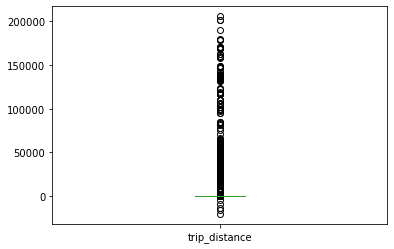

In [8]:
big_frame.boxplot(column=['trip_distance'], grid=False)

In [9]:
# Lets see how many trip distances are below 0
big_frame[big_frame['trip_distance']<0].shape[0]

19487

In [10]:
# Lets see how many fare_amounts are below 0
big_frame[big_frame['fare_amount']<0].shape[0]

73792

In [11]:
# Lets remove those data points as a negative trip_distance or fare_amount is most likely a false data input
big_frame = big_frame[big_frame['fare_amount']>0]
big_frame = big_frame[big_frame['trip_distance']>0]

In [12]:
#It seems that the trip_distance may be right-skewed with a long tail of very long distances, to confirm this lets determine the skewness of the feature
big_frame['trip_distance'].skew()
#As seen with the value of 434, the data is right skewed to an extreme extent

434.6977163203225

In [13]:
#Lets try to remove the top 1% of trip_distance values to reduce the skew
big_frame = big_frame[(big_frame['trip_distance'] < big_frame['trip_distance'].quantile(0.99))]

In [14]:
#Fare amount Skew is a lot better now, altough it is still right-skewed
big_frame['trip_distance'].skew()

2.198071297436475

In [15]:
#Lets try to remove the top 1% of fare_amounts values to reduce the skew
big_frame = big_frame[(big_frame['fare_amount'] < big_frame['fare_amount'].quantile(0.99))]

In [16]:
#Trip distance Skew is a lot better now, altough it is still right-skewed
big_frame['fare_amount'].skew()

1.6310627344873283

In [17]:
big_frame.shape

(27210708, 19)

In [18]:
#For ease of intepretation, lets rename some categorical variables from numeric to text
# We will do the following transformation for payment_type: (1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip)
# We will do the following transformation for trip_type: (1= Street-hail; 2= Dispatch)
# We will do the following transformation for RateCodeID: (1= Standard rate; 2= JFK; 3= Newark; 4= Nassau or Westchester; 5= Negotiated fare; 6= Group ride)

big_frame['trip_type'] = big_frame['trip_type'].astype('category').cat.rename_categories({1:'Street-hail',2:'Dispatch'})
big_frame['payment_type'] = big_frame['payment_type'].astype('category').cat.rename_categories({1:'Credit Card',2:'Cash',3:'No Charge',4:'Dispute',5:'Unknown',6:'Voided trip'})
big_frame['RatecodeID'] = big_frame['RatecodeID'].astype('category').cat.rename_categories({1:'Standard rate',2:'JFK',3:'Newark',4:'Nassau or Westchester',5:'Negotiated fare',6:'Group ride'})

In [19]:
big_frame.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,1.00,2017-01-01 09:00:01.000,2017-01-01 09:03:56.000,N,Standard rate,74,41,1.00,0.70,5.00,0.00,0.50,0.00,0.00,0.30,5.80,Cash,Street-hail,NaN
1,1.00,2017-01-01 18:57:55.000,2017-01-01 19:01:16.000,N,Standard rate,42,41,1.00,0.70,5.00,0.00,0.50,0.00,0.00,0.30,5.80,Cash,Street-hail,NaN
2,2.00,2017-01-02 06:55:47.000,2017-01-02 06:58:54.000,N,Standard rate,42,41,1.00,0.70,5.00,0.00,0.50,0.00,0.00,0.30,5.80,Cash,Street-hail,NaN
3,2.00,2017-01-02 14:34:17.000,2017-01-02 14:39:29.000,N,Standard rate,74,41,1.00,0.70,5.00,0.00,0.50,0.00,0.00,0.30,5.80,Cash,Street-hail,NaN
4,1.00,2017-01-03 06:12:30.000,2017-01-03 06:15:56.000,N,Standard rate,42,41,1.00,0.70,5.00,0.00,0.50,0.00,0.00,0.30,5.80,Cash,Street-hail,NaN


In [20]:
# Before we can manipulate the date columns, we need to turn them from general objects to a datetime objects
big_frame['lpep_dropoff_datetime'] = pd.to_datetime(big_frame['lpep_dropoff_datetime'])
big_frame['lpep_pickup_datetime'] = pd.to_datetime(big_frame['lpep_pickup_datetime'])

In [21]:
big_frame['Week'] = big_frame['lpep_dropoff_datetime'].dt.isocalendar().week

In [22]:
#Looking at the weekly average
big_frame['Week'] = big_frame['lpep_dropoff_datetime'].dt.isocalendar().week
big_frame.groupby('Week').size().mean()

513409.58490566036

In [23]:
#Average distance travelled per trip
big_frame['trip_distance'].mean()

2.8071964283331035

In [24]:
#As you can see the busiest days of the week are Friday and Saturday, which makes sense since people are more likely to take trips 
big_frame['dow'] = big_frame['lpep_dropoff_datetime'].dt.dayofweek
big_frame['dow'] = big_frame['dow'].astype('category').cat.rename_categories({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
big_frame.groupby('dow').size().sort_values(ascending=False)

dow
Saturday     4375738
Friday       4322435
Thursday     3944218
Wednesday    3784095
Sunday       3697739
Tuesday      3615650
Monday       3470833
dtype: int64

In [25]:
#The busiest hours of the day are around evening time from 5-7pm, this may be due to people taking taxis home from work or going into the city after work
big_frame['hour'] = big_frame['lpep_dropoff_datetime'].dt.hour
big_frame.groupby('hour').size().sort_values(ascending=False)

hour
18    1946386
19    1849258
17    1770511
16    1636882
20    1560348
15    1516400
21    1401226
14    1364135
9     1343365
10    1309137
12    1285394
22    1282621
13    1273260
11    1267308
23    1153482
8     1132658
0      966603
1      693216
7      684220
2      493781
3      375288
4      337070
6      328854
5      239305
dtype: int64

In [26]:
#Most popular pick up locations
big_frame.groupby('PULocationID').size().sort_values(ascending=False)

PULocationID
74     1862801
75     1597816
41     1557466
7      1281744
82     1189977
        ...   
84          12
204         11
12           9
99           5
199          1
Length: 261, dtype: int64

In [27]:
#Most popular drop off locations
big_frame.groupby('DOLocationID').size().sort_values(ascending=False)

DOLocationID
74     974758
42     941596
41     840491
7      802970
129    738791
        ...  
84         45
204        23
99         15
105         7
110         1
Length: 262, dtype: int64

In [28]:
#Lets predict what factors affect the odds of getting a tip, since cash tips are not counted in the dataset, lets see how many of the payments are done in cash
big_frame['payment_type'].value_counts()

Credit Card    14183683
Cash           12109752
No Charge         67763
Dispute           39930
Unknown             922
Name: payment_type, dtype: int64

In [29]:
#As seen, very few tips are recorded when the payment type is Cash, so lets exclude cash payments from the training set as this may bias our results
big_frame[(big_frame['payment_type']=='Cash') & (big_frame['tip_amount'] > 0 )]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,Week,dow,hour
14529942,1.00,2018-03-18 15:27:49,2018-03-18 16:45:17,N,Standard rate,85,85,1.00,10.30,26.49,...,4.09,0.00,0.30,31.38,Cash,Street-hail,NaN,11,Sunday,16
21171175,1.00,2019-05-20 19:11:45,2019-05-20 19:26:51,N,Standard rate,75,238,3.00,2.50,12.00,...,1.66,0.00,0.30,18.21,Cash,Street-hail,2.75,21,Monday,19
21224270,1.00,2019-04-17 07:39:47,2019-04-17 08:12:21,N,Standard rate,41,164,1.00,4.60,21.50,...,3.76,0.00,0.30,28.81,Cash,Street-hail,2.75,16,Wednesday,8
21224271,1.00,2019-04-19 06:58:19,2019-04-19 07:18:44,N,Standard rate,42,48,1.00,5.00,18.50,...,4.41,0.00,0.30,26.46,Cash,Street-hail,2.75,16,Friday,7
21224272,1.00,2019-04-21 11:44:08,2019-04-21 11:52:24,N,Standard rate,49,97,1.00,1.60,8.00,...,0.88,0.00,0.30,9.68,Cash,Street-hail,0.00,16,Sunday,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27630530,1.00,2020-02-03 12:57:47,2020-02-03 12:59:17,N,Standard rate,149,165,1.00,0.70,4.00,...,0.79,0.00,0.30,6.09,Cash,Street-hail,0.00,6,Monday,12
27777175,1.00,2020-01-25 18:45:20,2020-01-25 19:04:37,N,Standard rate,61,227,1.00,3.90,16.00,...,2.52,0.00,0.30,19.32,Cash,Street-hail,0.00,4,Saturday,19
27777177,1.00,2020-03-11 12:33:43,2020-03-11 12:45:39,N,Standard rate,42,69,1.00,2.10,10.00,...,1.08,0.00,0.30,11.88,Cash,Street-hail,0.00,11,Wednesday,12
27777180,1.00,2020-03-13 15:45:43,2020-03-13 15:56:50,N,Standard rate,166,236,1.00,1.70,9.50,...,2.06,0.00,0.30,12.36,Cash,Street-hail,0.00,11,Friday,15


In [30]:
#For this purpose, lets only look at the subset of the data where a Credit Card was used as payment method
big_framec = big_frame[big_frame['payment_type'] == 'Credit Card']

In [31]:
big_framec['tip'] = big_framec['tip_amount'].apply(lambda x: 1 if x > 0 else 0)

C:\Users\awais\AppData\Local\Temp/ipykernel_5252/2615569790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_framec['tip'] = big_framec['tip_amount'].apply(lambda x: 1 if x > 0 else 0)


In [32]:
big_framec['tip'].value_counts()

1    10604865
0     3578818
Name: tip, dtype: int64

<AxesSubplot:>

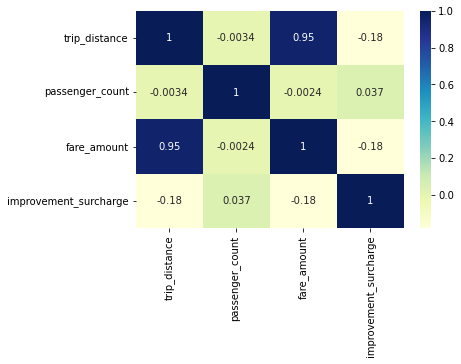

In [33]:
#As seen in the corr heatmap, trip_distance and fare_amount are highly correlared, which makes sense but it means one of these features would need to be removed from our data
sns.heatmap(big_framec[['trip_distance','passenger_count','fare_amount','trip_type','improvement_surcharge']].corr(), cmap='YlGnBu',annot=True)

In [34]:
#Turning trip_type into a binary classification for our model and replacing NaN values
big_framec['StreetH'] = big_framec['trip_type'].apply(lambda x: 1 if x == 'Street-hail' else 0)
big_framec['StreetH'] = big_framec['StreetH'].fillna(0)

C:\Users\awais\AppData\Local\Temp/ipykernel_5252/3672174334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_framec['StreetH'] = big_framec['trip_type'].apply(lambda x: 1 if x == 'Street-hail' else 0)
C:\Users\awais\AppData\Local\Temp/ipykernel_5252/3672174334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_framec['StreetH'] = big_framec['StreetH'].fillna(0)


In [35]:
# A very simple LR model

target = big_framec.tip
features = big_framec[['passenger_count','trip_distance','improvement_surcharge','StreetH']]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.30)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

acc_lr = metrics.accuracy_score(y_test, y_pred_lr)
conf = metrics.confusion_matrix(y_test, y_pred_lr)
clf_report = metrics.classification_report(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")


Accuracy Score of Logistic Regression is : 0.7627275942661814
Confusion Matrix : 
[[  82259  991402]
 [  18217 3163227]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.82      0.08      0.14   1073661
           1       0.76      0.99      0.86   3181444

    accuracy                           0.76   4255105
   macro avg       0.79      0.54      0.50   4255105
weighted avg       0.78      0.76      0.68   4255105



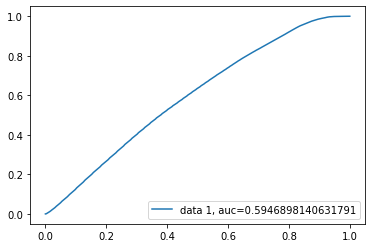

In [36]:
# ROC Score
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [37]:
big_frame_sam = big_framec.sample(n=140000)
feature_sample = big_frame_sam[['passenger_count','trip_distance','improvement_surcharge','StreetH']]
target_sample = big_frame_sam.tip
X_train, X_test, y_train, y_test = train_test_split(feature_sample, target_sample, test_size = 0.30)
pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', LogisticRegression()) #step2 - classifier
])
pipeline.steps
from sklearn.model_selection import cross_validate

scores = cross_validate(pipeline, X_train, y_train)
scores

{'fit_time': array([0.05482841, 0.05585074, 0.0627532 , 0.05884218, 0.05585074]),
 'score_time': array([0.00299215, 0.00299191, 0.00299263, 0.00299263, 0.00299215]),
 'test_score': array([0.76397959, 0.76607143, 0.76326531, 0.7622449 , 0.76209184])}

In [38]:
# We will try the following classifiers in the pipeline LogisticRegression, Support Vector Machines - linear and rbf, K-nearest Classifier, Decision Tree Classifier, Gradient Bossting Classifier
# Looks like SVC is the best classifier
clfs = []
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier())

for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

---------------------------------
SVC()
-----------------------------------
fit_time  mean  222.6214303970337
fit_time  std  29.772101662216755
score_time  mean  42.8565279006958
score_time  std  0.39909213806299315
test_score  mean  0.763326530612245
test_score  std  0.0013649842517395043
---------------------------------
KNeighborsClassifier(n_neighbors=3)
-----------------------------------
fit_time  mean  2.7016648292541503
fit_time  std  0.029615260538562713
score_time  mean  1.3090702533721923
score_time  std  0.014620595694234175
test_score  mean  0.7071530612244897
test_score  std  0.003578477009747018
---------------------------------
DecisionTreeClassifier()
-----------------------------------
fit_time  mean  0.06100521087646484
fit_time  std  0.005712745856633534
score_time  mean  0.0040626049041748045
score_time  std  0.00014557998530147687
test_score  mean  0.7485102040816326
test_score  std  0.0014254338722934766
---------------------------------
RandomForestClassifier()


In [39]:
#Lets optimise our SVC hypterparameters using GridSearchCV
from sklearn.model_selection import GridSearchCV
pipeline.set_params(clf= SVC())
pipeline.steps

[('normalizer', StandardScaler()), ('clf', SVC())]

In [40]:
cv_grid = GridSearchCV(pipeline, param_grid = {
    'clf__kernel' : ['linear', 'rbf'],
    'clf__C' : np.linspace(0.1,1.2,12)
})

cv_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('normalizer', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2]),
                         'clf__kernel': ['linear', 'rbf']})

In [41]:
cv_grid.best_params_

{'clf__C': 0.2, 'clf__kernel': 'rbf'}

In [42]:
cv_grid.cv_results_

{'mean_fit_time': array([ 69.566014  , 180.55391464,  74.21313334, 188.18034201,
         74.78583126, 194.6967545 ,  66.33060431, 212.53113861,
         65.27194524, 226.32591624,  67.00009365, 231.16043777,
         64.2748837 , 211.67399802,  64.83310485, 208.87264194,
         72.46104317, 208.69276128,  64.99092779, 217.97477784,
         72.03968167, 234.48948102,  68.4957211 , 233.85989132]),
 'std_fit_time': array([ 1.25655798, 17.42042937,  2.64879602, 34.45959044,  1.77517748,
        24.52615202,  6.52874393, 24.91971548,  8.73010144, 42.04077184,
         7.78097271, 54.90991359,  6.50577682, 20.82132599,  6.32012194,
        37.7146229 ,  6.77408743, 36.80777445,  6.37572064, 51.70876443,
         9.24808324, 40.30246061, 10.5888046 , 44.97113905]),
 'mean_score_time': array([10.8992178 , 43.72803535, 11.57901764, 44.98896327, 11.59451041,
        44.33063884, 11.04810796, 44.69292936, 11.34885588, 45.35587773,
        11.43633461, 43.15008492, 10.7126111 , 44.38728271, 10

In [43]:
# This is best score we have achieved, there is still optimisation to be done to get a better score
cv_grid.best_score_

0.7635612244897959